### Experiment Settings

In [147]:
epochs = 5
max_len = 100

In [2]:
# Experiment_name
experiment_name = 'basline_entire_dataset'

# Naming: model
model_path = '/content/drive/My Drive/CBB-750/Final Project/model/' + experiment_name + '.pt'
print(model_path)

# Naming: training history
training_df_path = '/content/drive/My Drive/CBB-750/Final Project/history/' + experiment_name + '.csv'
print(training_df_path)

/content/drive/My Drive/CBB-750/Final Project/model/basline_entire_dataset.pt
/content/drive/My Drive/CBB-750/Final Project/history/basline_entire_dataset.csv


### GPU

In [3]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Dataset

In [6]:
# load the file into a dataframe
import pandas as pd
import numpy as np
df = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/data.xlsx') 
df

,Quotation Content,Codes
0,197 I noticed that my medication list has not ...,Information-Giving
1,Blood in urine and stool- began yesterday We a...,Information-Giving
2,Can someone set up that appointment as I do no...,Information-Giving
3,Dear Doctor Lacy I just was told my daughter w...,Information-Giving
4,Dear Dr Chiang When I saw you last Thursday( M...,Information-Giving
...,...,...
256,Thank you for the update I will speak to the t...,Partnership
257,Yes:) I will have put in lab orders,Partnership
258,Only 4 left Has renewal been sent in How can w...,Partnership
259,Dear Dr Chiang When I saw you last Thursday( M...,Partnership


In [7]:
df

,Quotation Content,Codes
0,197 I noticed that my medication list has not ...,Information-Giving
1,Blood in urine and stool- began yesterday We a...,Information-Giving
2,Can someone set up that appointment as I do no...,Information-Giving
3,Dear Doctor Lacy I just was told my daughter w...,Information-Giving
4,Dear Dr Chiang When I saw you last Thursday( M...,Information-Giving
...,...,...
256,Thank you for the update I will speak to the t...,Partnership
257,Yes:) I will have put in lab orders,Partnership
258,Only 4 left Has renewal been sent in How can w...,Partnership
259,Dear Dr Chiang When I saw you last Thursday( M...,Partnership


In [8]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.8 MB/s eta 0:00:00
Running GPU: Tesla T4


In [9]:
possible_labels = df.Codes.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Information-Giving': 0,
 'Information-Seeking': 1,
 'Emotion': 2,
 'Partnership': 3}

In [10]:
df['label'] = df.Codes.replace(label_dict)
df['text'] = df['Quotation Content']

In [11]:
df.head()


,Quotation Content,Codes,label,text
0,197 I noticed that my medication list has not ...,Information-Giving,0,197 I noticed that my medication list has not ...
1,Blood in urine and stool- began yesterday We a...,Information-Giving,0,Blood in urine and stool- began yesterday We a...
2,Can someone set up that appointment as I do no...,Information-Giving,0,Can someone set up that appointment as I do no...
3,Dear Doctor Lacy I just was told my daughter w...,Information-Giving,0,Dear Doctor Lacy I just was told my daughter w...
4,Dear Dr Chiang When I saw you last Thursday( M...,Information-Giving,0,Dear Dr Chiang When I saw you last Thursday( M...


<Axes: xlabel='label', ylabel='Count'>

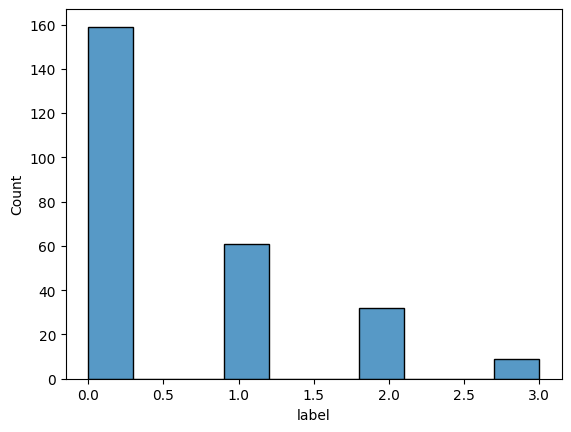

In [12]:
import seaborn as sns
sns.histplot(df['label'])

### Data Split

In [148]:
from sklearn.model_selection import train_test_split

df_train, df_rem = train_test_split(df,
                                    test_size=0.3,
                                    random_state=1,
                                    stratify=df['label'])

df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=1,
                                    stratify=df_rem['label'])


Shape: (182, 4)
Shape: (39, 4)
Shape: (40, 4)


<Axes: xlabel='label', ylabel='Count'>

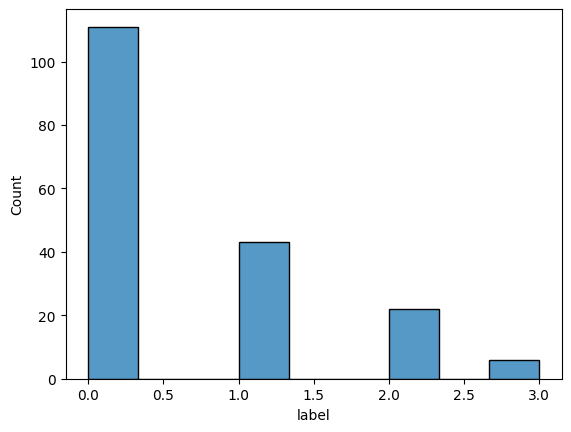

In [149]:
for item in df_train, df_val, df_test:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution    
sns.histplot(df_train['label'])

### Tokenization

In [150]:
from transformers import BertTokenizer

# Load BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          do_lower_case=True)

In [151]:
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['Quotation Content']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        max_length=max_len,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [152]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

In [153]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['label'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [154]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)
test_dataloader = get_dataloader(df_test)


### Import BERT

In [155]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [156]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [157]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

### Training

In [158]:
# Import materics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [159]:
# Reset history lists
training_stats = []

for epoch_i in range(epochs):
    
    # timer_start
    epoch_t0 = time.time()
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    
    
    # timer_end
    epoch_time_spent = time.time() - epoch_t0
    print('  Time spent on the epoch: {:.2f}'.format(epoch_time_spent))
    print('\n')
    
    # Recording training stats
    training_stats.append(
        {
            'Epoch': epoch_i+1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_acc': acc,
            'time_spent': epoch_time_spent
        })

【EPOCH: 1/ 5】
Trainig Phase
  Average training loss: 1.3621
Validation Phase
  Average validation loss: 1.3381
  Validation accruacy: 0.5128
  Time spent on the epoch: 3.23


【EPOCH: 2/ 5】
Trainig Phase
  Average training loss: 1.1869
Validation Phase
  Average validation loss: 1.1265
  Validation accruacy: 0.6154
  Time spent on the epoch: 3.25


【EPOCH: 3/ 5】
Trainig Phase
  Average training loss: 1.0255
Validation Phase
  Average validation loss: 1.0854
  Validation accruacy: 0.6154
  Time spent on the epoch: 3.27


【EPOCH: 4/ 5】
Trainig Phase
  Average training loss: 0.9889
Validation Phase
  Average validation loss: 0.9762
  Validation accruacy: 0.5897
  Time spent on the epoch: 3.30


【EPOCH: 5/ 5】
Trainig Phase
  Average training loss: 0.9127
Validation Phase
  Average validation loss: 0.8895
  Validation accruacy: 0.6154
  Time spent on the epoch: 3.32




### Training performance

In [160]:
train_loss = []
val_loss = []
val_acc = []
time_spent = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    val_loss.append(training_stats[i]['val_loss'])
    val_acc.append(training_stats[i]['val_acc'])
    time_spent.append(training_stats[i]['time_spent'])

Time spent on training 5 epochs: 0 minutes


Text(0.5, 1.0, 'accuracy')

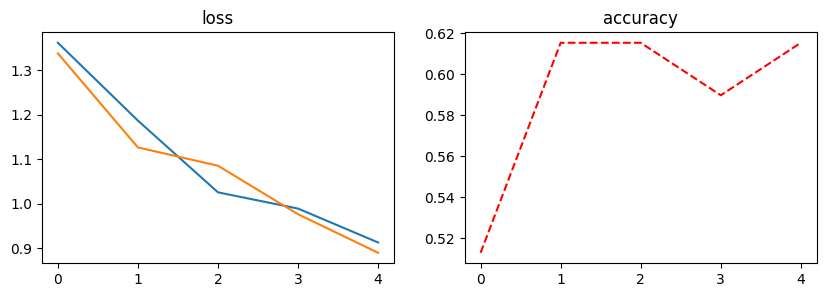

In [161]:
# Print time spent
print('Time spent on training {} epochs: {:.0f}'.format(epochs, np.sum(time_spent)/60) + ' minutes')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(val_acc, color='red', linestyle='--')
plt.title('accuracy')

In [162]:
torch.save(model.state_dict(), model_path)

### Perform on the test data

In [163]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

Number of batches in the dataloader: 2


In [164]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)

In [165]:
# Set up list of test labels
ls_test_labels = df_test['Codes'].values
rev_subs = { v:k for k,v in label_dict.items()}
ls_test_pred = [rev_subs.get(item,item)  for item in ls_test_pred]
# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.5750


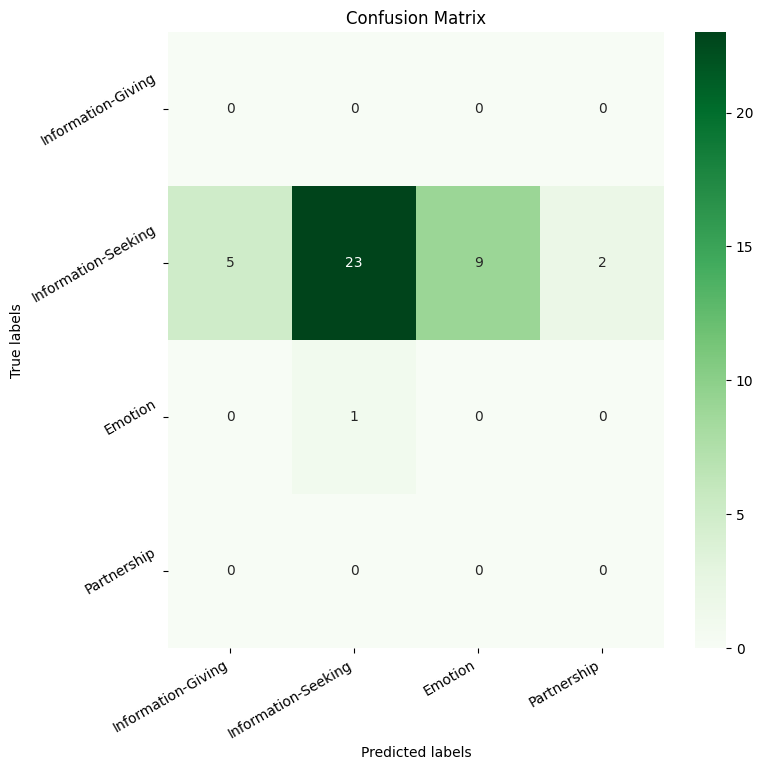

                     precision    recall  f1-score   support

 Information-Giving       0.59      0.96      0.73        24
Information-Seeking       0.00      0.00      0.00         9
            Emotion       0.00      0.00      0.00         5
        Partnership       0.00      0.00      0.00         2

           accuracy                           0.57        40
          macro avg       0.15      0.24      0.18        40
       weighted avg       0.35      0.57      0.44        40



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
# Confusion matrix
cm = confusion_matrix(ls_test_pred, ls_test_labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(ls_test_labels,ls_test_pred,labels=labels))